## pysam multithreading

I recently came across a situation where I needed to use pysam to convert a sam file to a bam file as a part of [TALON](). As samtools view contains a multithreading option (`-@ <int>`)

Sources: 
* https://github.com/pysam-developers/pysam/issues/677
* https://github.com/pysam-developers/pysam/issues/524
* https://github.com/pysam-developers/pysam/pull/638
* https://github.com/pysam-developers/pysam/issues/579
* https://www.tutorialspoint.com/How-to-find-difference-between-2-files-in-Python
* https://stackoverflow.com/questions/16874598/how-do-i-calculate-the-md5-checksum-of-a-file-in-python
* https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution
* https://stackoverflow.com/questions/7585307/how-to-correct-typeerror-unicode-objects-must-be-encoded-before-hashing

In [ ]:
import pysam
import time
import seaborn as sns
import pandas as pd
import hashlib

In [7]:
def benchmark_write(threads=1):
    infile = pysam.AlignmentFile('uhr_min.sam', 'r', threads=threads)
    outfile = pysam.AlignmentFile('uhr_min_pysam.bam', mode='wb', template=infile, threads=threads)
    for s in infile:
        outfile.write(s)

In [23]:
df = pd.DataFrame(data=[i for i in range(1,9)], columns=['threads'])
print(df)

   threads
0        1
1        2
2        3
3        4
4        5
5        6
6        7
7        8


In [24]:
for i in range(10):
    times = []
    
    for j in range(1,9):
        start = time.time()
        benchmark_write(j)
        times.append(time.time()-start)
    df[i] = times

In [25]:
df

,threads,0,1,2,3,4,5,6,7,8,9
0,1,0.282870,0.265184,0.262383,0.261981,0.267385,0.267241,0.263017,0.302322,0.277804,0.286572
1,2,0.265000,0.259121,0.263626,0.259267,0.263356,0.261341,0.261066,0.285738,0.277101,0.270543
2,3,0.155507,0.148933,0.153035,0.150145,0.148652,0.144996,0.175249,0.154428,0.176301,0.151375
3,4,0.112295,0.111242,0.112823,0.116677,0.110538,0.105395,0.110949,0.113276,0.115702,0.109067
4,5,0.094919,0.088845,0.095793,0.090943,0.092149,0.093266,0.095547,0.094460,0.091257,0.092118
5,6,0.074468,0.079772,0.077461,0.076175,0.079677,0.077980,0.083296,0.074861,0.094027,0.077852
6,7,0.066870,0.070661,0.069208,0.069645,0.070049,0.069167,0.073265,0.068944,0.071436,0.069442
7,8,0.064417,0.061893,0.063817,0.063894,0.064350,0.065580,0.067776,0.065079,0.070778,0.063519


In [26]:
df = df.melt(id_vars='threads', value_vars=[i for i in range(10)])

In [28]:
df.rename({'value':'time (seconds)'}, axis=1, inplace=True)

In [29]:
df

,threads,variable,time (seconds)
0,1,0,0.282870
1,2,0,0.265000
2,3,0,0.155507
3,4,0,0.112295
4,5,0,0.094919
...,...,...,...
75,4,9,0.109067
76,5,9,0.092118
77,6,9,0.077852
78,7,9,0.069442


<AxesSubplot:xlabel='threads', ylabel='time (seconds)'>

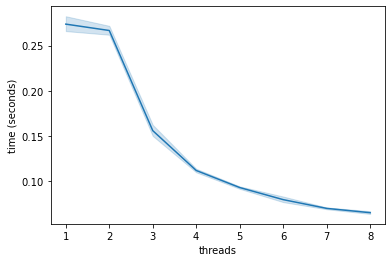

In [30]:
sns.lineplot(data=df, x='threads', y='time (seconds)')

As we can see, even on just ~3000 sequences, multithreading SAM -> BAM compression provides considerable speedup. 

To verify that we the multithreaded version gave us the correct output files, let's check if the contents of our files are the same. NOTE: samtools operations add additional lines to the file headers so we WON'T be checking the file headers!

In [5]:
# sort and convert to sam without the headers

# control - made with `samtools view -Sb sam > bam`
infile = 'uhr_min.bam'
ofile = 'uhr_min_sorted.bam'
pysam.sort('-o', ofile, infile)
ofile_sam = 'uhr_min_sorted.sam'
pysam.view('-o', ofile_sam, ofile, save_stdout=ofile_sam)

# pysam multithreaded bam we just wrote
infile = 'uhr_min_pysam.bam'
ofile = 'uhr_min_pysam_sorted.bam'
pysam.sort('-o', ofile, infile)
ofile_sam = 'uhr_min_pysam_sorted.sam'
pysam.view('-o', ofile_sam, ofile, save_stdout=ofile_sam)

```bash
diff uhr_min_sorted.sam uhr_min_pysam_sorted.sam
```

In [16]:
# with open('uhr_min_sorted.sam') as f1:
#     f1_text = f1.read()
# with open('uhr_min_pysam_sorted.sam') as f2:
#     f2_text = f2.read()
# # # Find and print the diff:
# # for line in difflib.unified_diff(f1_text, f2_text, fromfile='file1', tofile='file2', lineterm=''):
# #     print(line)

In [ ]:
# beep = difflib.unified_diff(f1_text, f2_text, fromfile='file1', tofile='file2', lineterm='')
# for b in beep:
#     print(b)

No output, which means the files are the same! To make sure though, we'll also check the md5sums, which should be identical.

In [14]:
ctrl_md5 = hashlib.md5(open('uhr_min_sorted.sam','rb').read()).hexdigest()
pysam_md5 = hashlib.md5(open('uhr_min_pysam_sorted.sam','rb').read()).hexdigest()

ctrl_md5 == pysam_md5

True

The comparison shows that the two are equivalent, so we are good!

```bash
module load samtools

# sort, convert only sequences to sam

# control - made with `samtools view -Sb sam > bam`
samtools sort uhr_min.bam > uhr_min_sorted.bam
samtools view uhr_min_sorted.bam > uhr_min_sorted.sam

# pysam multithreaded version that we just made
samtools sort uhr_min_pysam.bam > uhr_min_pysam_sorted.bam
samtools view uhr_min_pysam_sorted.bam > uhr_min_pysam_sorted.sam

diff uhr_min_sorted.sam uhr_min_pysam_sorted.sam
```

No output, so the file contents are the same! Just to check though, lets compute the md5sum of each file, which should be identical.

```bash
md5sum uhr_min_sorted.sam
md5sum uhr_min_pysam_sorted.sam
```

> 8d6f8db5633ec1ae4ec40435b0850559  uhr_min_sorted.sam
> 8d6f8db5633ec1ae4ec40435b0850559  uhr_min_pysam_sorted.sam

So we're good!